In [1]:

# =========================
# 0) IMPORTS (1 cell duy nhất)
# =========================
import os, glob, random
import numpy as np
import cv2
import matplotlib.pyplot as plt

import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.utils import shuffle

import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from skimage.feature import hog


In [2]:

# =========================
# 1) CONFIG
# =========================
DATASET_ROOT = r"C:\Users\PC\.cache\kagglehub\datasets\mbornoe\lisa-traffic-light-dataset\versions\2"  # <-- sửa path này

RANDOM_SEED = 42
TEST_SIZE = 0.2
MAX_SAMPLES = 20000

LABEL_MAP = {0: "other", 1: "green", 2: "red", 3: "yellow"}
ID2NAME = {0:"other",1:"green",2:"red",3:"yellow"}

os.makedirs("outputs", exist_ok=True)

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))
print("DATASET_ROOT:", DATASET_ROOT)


TensorFlow: 2.20.0
GPU available: False
DATASET_ROOT: C:\Users\PC\.cache\kagglehub\datasets\mbornoe\lisa-traffic-light-dataset\versions\2


In [3]:

# =========================
# 2) HELPERS
# =========================
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        tf.random.set_seed(seed)
    except Exception:
        pass

seed_everything(RANDOM_SEED)

# --- dataset loader (từ file dataset_lisa.py bạn đã có) ---
from dataset_lisa import build_patch_dataset_from_box_csvs

# --- HOG feature extractor (từ file features_hog.py bạn đã có) ---
from features_hog import hog_batch

def build_vgg16_feature_extractor():
    base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
    model = tf.keras.Sequential([base, tf.keras.layers.GlobalAveragePooling2D()])
    return model

def vgg16_features(model, X_patches_uint8, batch_size=64):
    X = X_patches_uint8.astype(np.float32)
    X = preprocess_input(X)
    feats = model.predict(X, batch_size=batch_size, verbose=1)
    return feats.astype(np.float32)

def train_eval_svm(X_train, y_train, X_test, y_test, out_path):
    svm = make_pipeline(
        StandardScaler(),
        SVC(C=2.0, kernel="rbf", probability=True)
    )
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)

    acc = accuracy_score(y_test, pred)
    print("Accuracy:", acc)
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred, target_names=[LABEL_MAP[i] for i in sorted(set(y_test))]))

    joblib.dump(svm, out_path)
    print("Saved:", out_path)
    return svm, acc

def plot_confmat(cm, class_names, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()


Building dataset from LISA annotations...
Patches: (20000, 64, 64, 3) Labels: (20000,)
Label distribution:
0 other : 9670
1 green : 5871
2 red : 4167
3 yellow : 292


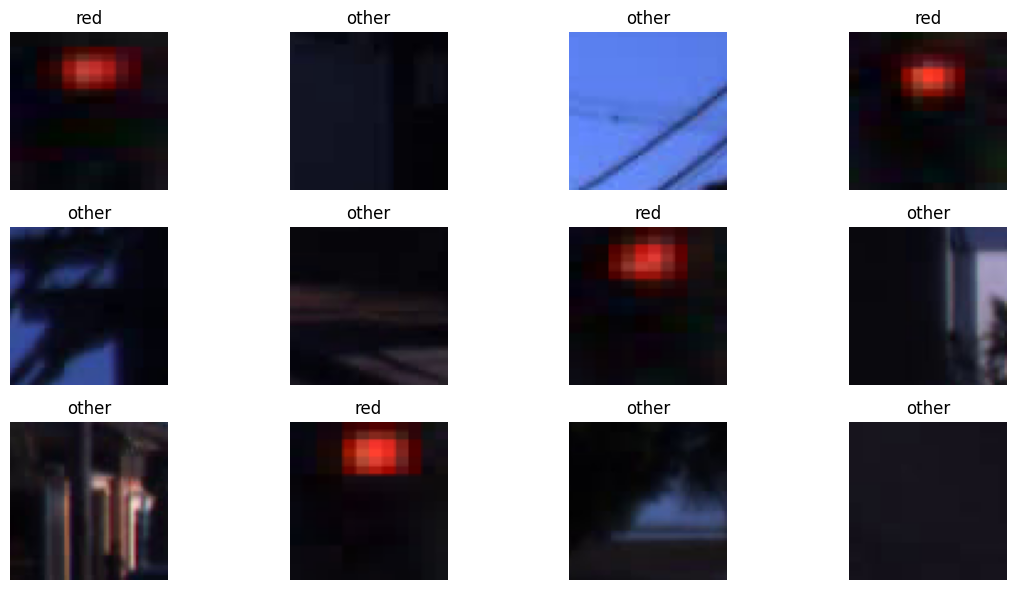

In [4]:

# =========================
# 3) LOAD PATCH DATASET (from BOX annotations)
# =========================
print("Building dataset from LISA annotations...")
X_patches, y = build_patch_dataset_from_box_csvs(
    dataset_root=DATASET_ROOT,
    max_samples=MAX_SAMPLES,
    add_other=True,
    n_other_per_image=2,      # 2–4 là hợp lý
    other_max_iou=0.02,
    seed=42
)

print("Patches:", X_patches.shape, "Labels:", y.shape)
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:")
for u, c in zip(unique, counts):
    print(u, LABEL_MAP.get(int(u), str(u)), ":", int(c))

# quick visualize
nshow = min(12, len(X_patches))
plt.figure(figsize=(12, 6))
for i in range(nshow):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_patches[i])
    plt.title(LABEL_MAP[int(y[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


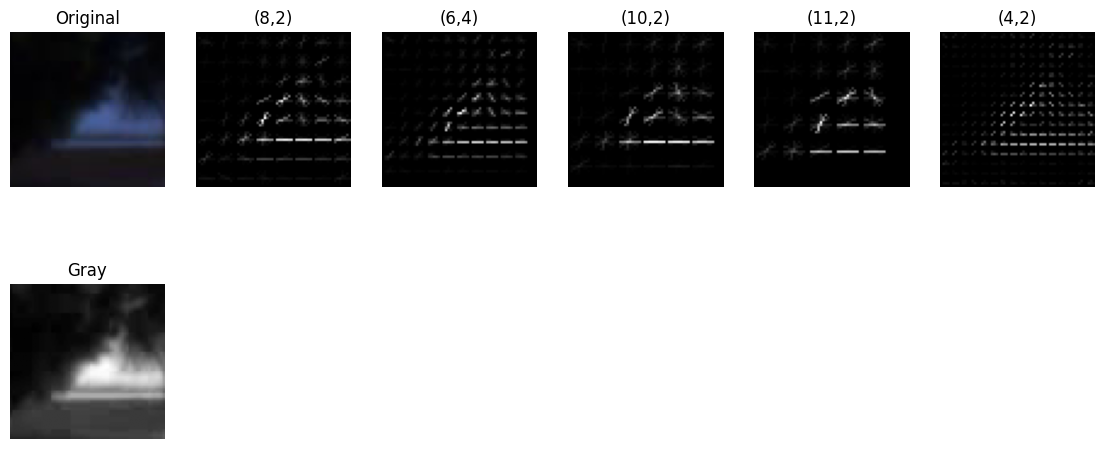

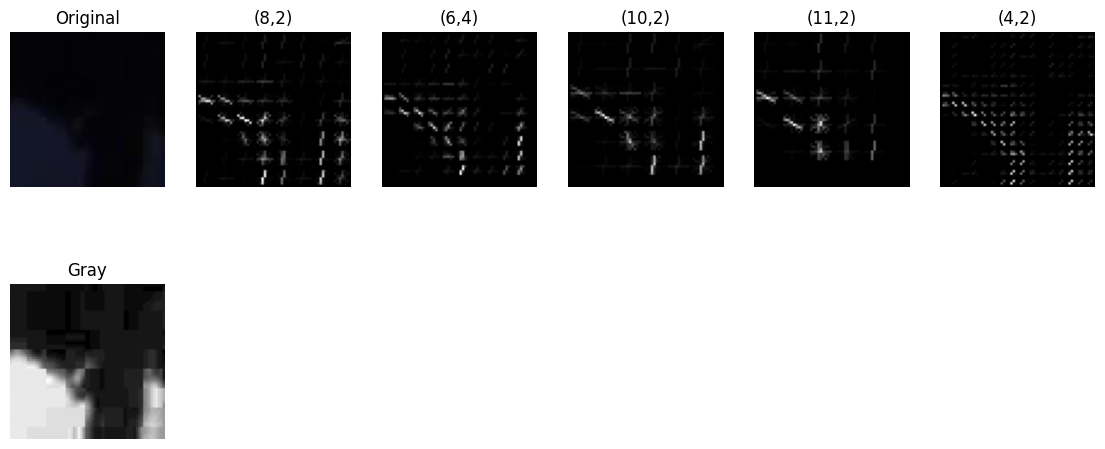

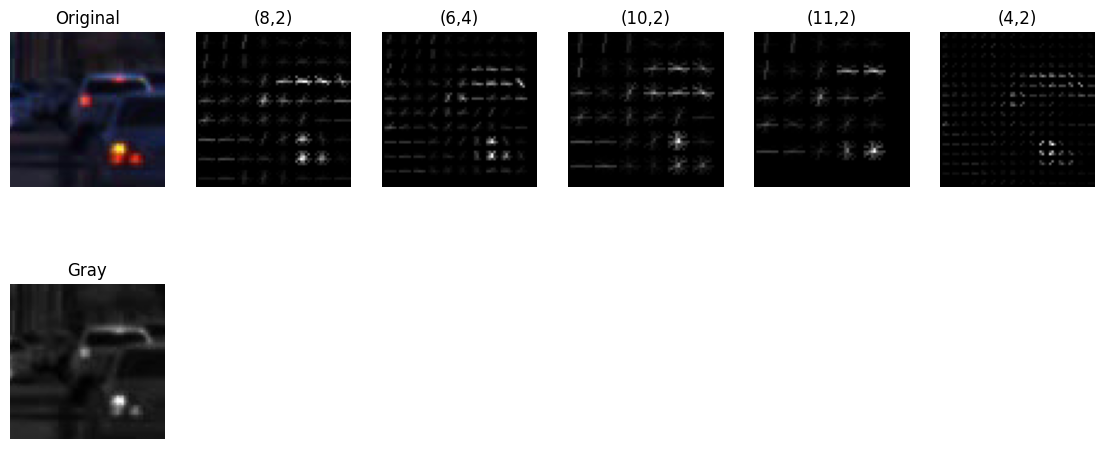

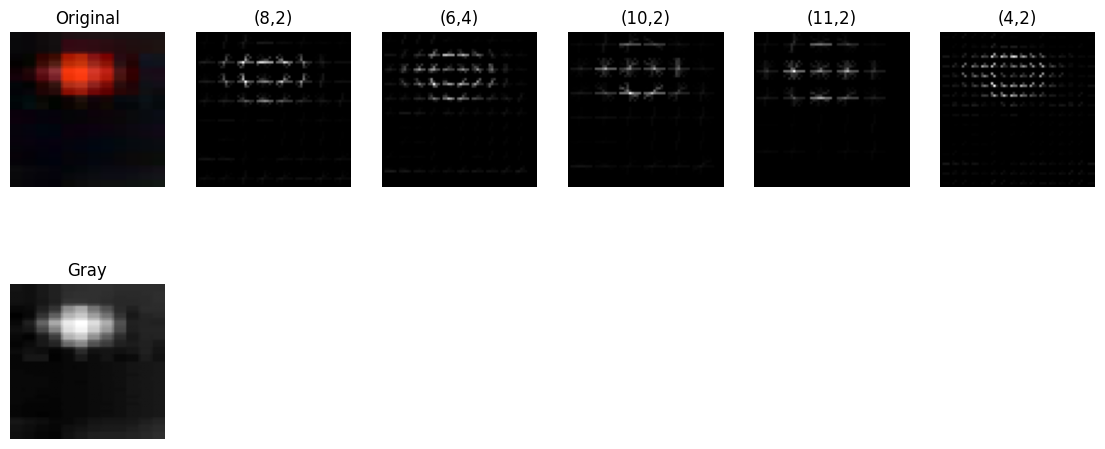

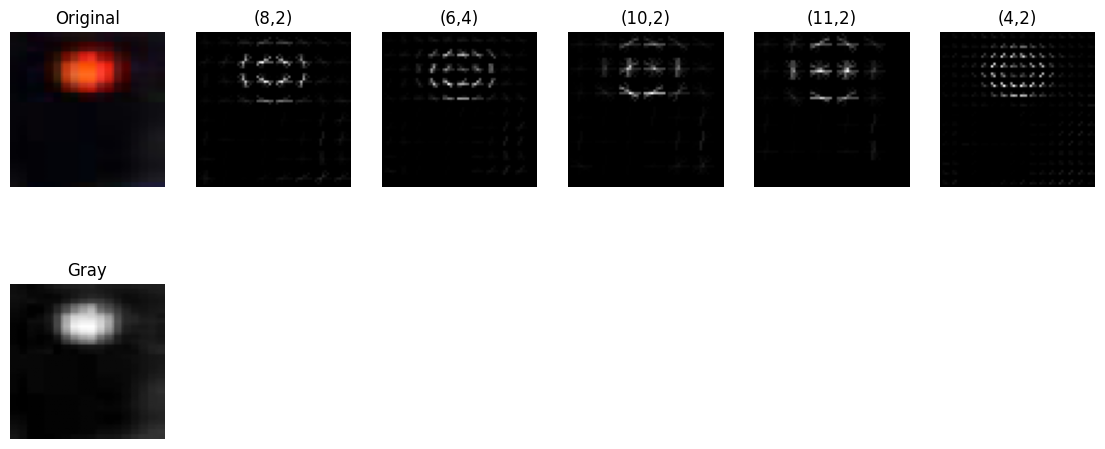

In [9]:
def visualize_hog_params(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    configs = [(8,2),(6,4),(10,2),(11,2),(4,2)]


    plt.figure(figsize=(14,6))
    plt.subplot(2, len(configs)+1, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')


    plt.subplot(2, len(configs)+1, len(configs)+2)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Gray")
    plt.axis('off')


    for i,(cell,block) in enumerate(configs):
        _, hog_img = hog(img_gray, orientations=9,
        pixels_per_cell=(cell,cell),
        cells_per_block=(block,block),
        visualize=True, block_norm='L2-Hys')
        plt.subplot(2, len(configs)+1, i+2)
        plt.imshow(hog_img, cmap='gray')
        plt.title(f"({cell},{block})")
        plt.axis('off')
    plt.show()


visualize_hog_params(X_patches[10])
visualize_hog_params(X_patches[50])
visualize_hog_params(X_patches[100])
visualize_hog_params(X_patches[150])
visualize_hog_params(X_patches[400])

In [6]:

# =========================
# 4) TRAIN/TEST SPLIT 
# =========================
X_train_p, X_test_p, y_train, y_test = train_test_split(
    X_patches, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Train patches:", X_train_p.shape, "Test patches:", X_test_p.shape)


Train patches: (16000, 64, 64, 3) Test patches: (4000, 64, 64, 3)


In [7]:

# =========================
# 5) HOG FEATURES
# =========================
X_train_hog = hog_batch(X_train_p)
X_test_hog = hog_batch(X_test_p)

print("HOG train feat:", X_train_hog.shape, "HOG test feat:", X_test_hog.shape)


HOG train feat: (16000, 1176) HOG test feat: (4000, 1176)


In [8]:

# =========================
# 7) VGG16 (freeze) FEATURES
# =========================
print("Loading VGG16 feature extractor (freeze)...")
vgg_model = build_vgg16_feature_extractor()

X_train_vgg = vgg16_features(vgg_model, X_train_p, batch_size=64)
X_test_vgg  = vgg16_features(vgg_model, X_test_p, batch_size=64)

print("VGG train feat:", X_train_vgg.shape, "VGG test feat:", X_test_vgg.shape)

Loading VGG16 feature extractor (freeze)...
250/250 ━━━━━━━━━━━━━━━━━━━━ 92s 368ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step
VGG train feat: (16000, 512) VGG test feat: (4000, 512)


In [9]:
from sklearn.model_selection import cross_validate

print("=== CROSS-VALIDATION COMPARISON (TRAIN SET ONLY) ===")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring = {
    "acc": "accuracy",
    "f1_macro": "f1_macro"
}

pipe = make_pipeline(
    StandardScaler(),
    SVC(C=2.0, kernel="rbf", probability=True)
)

# HOG
res_hog = cross_validate(
    pipe,
    X_train_hog, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# VGG
res_vgg = cross_validate(
    pipe,
    X_train_vgg, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print(
    "HOG  | acc = %.3f ± %.3f | f1_macro = %.3f ± %.3f"
    % (
        res_hog["test_acc"].mean(),
        res_hog["test_acc"].std(),
        res_hog["test_f1_macro"].mean(),
        res_hog["test_f1_macro"].std(),
    )
)

print(
    "VGG  | acc = %.3f ± %.3f | f1_macro = %.3f ± %.3f"
    % (
        res_vgg["test_acc"].mean(),
        res_vgg["test_acc"].std(),
        res_vgg["test_f1_macro"].mean(),
        res_vgg["test_f1_macro"].std(),
    )
)


=== CROSS-VALIDATION COMPARISON (TRAIN SET ONLY) ===
HOG  | acc = 0.993 ± 0.001 | f1_macro = 0.993 ± 0.002
VGG  | acc = 0.994 ± 0.002 | f1_macro = 0.990 ± 0.002



===== HOG =====
hog TEST accuracy: 0.99625
[[1932    1    1    0]
 [   6 1167    1    0]
 [   5    0  829    0]
 [   1    0    0   57]]
              precision    recall  f1-score   support

       other       0.99      1.00      1.00      1934
       green       1.00      0.99      1.00      1174
         red       1.00      0.99      1.00       834
      yellow       1.00      0.98      0.99        58

    accuracy                           1.00      4000
   macro avg       1.00      0.99      1.00      4000
weighted avg       1.00      1.00      1.00      4000



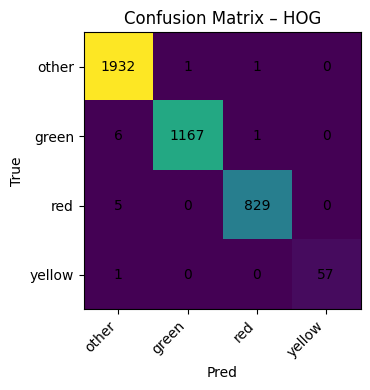


===== VGG16 =====
vgg16 TEST accuracy: 0.99475
[[1930    1    3    0]
 [   6 1168    0    0]
 [   8    2  824    0]
 [   0    0    1   57]]
              precision    recall  f1-score   support

       other       0.99      1.00      1.00      1934
       green       1.00      0.99      1.00      1174
         red       1.00      0.99      0.99       834
      yellow       1.00      0.98      0.99        58

    accuracy                           0.99      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



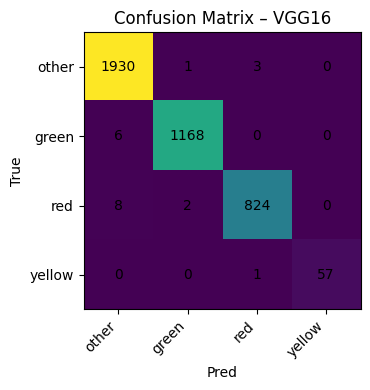


Best feature selected: hog


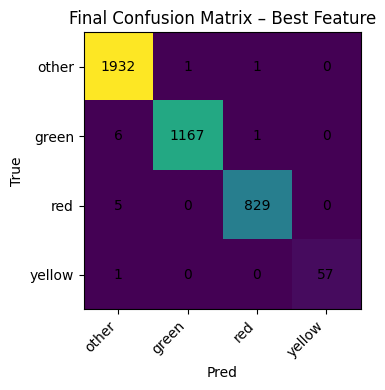

In [10]:
labels = [0, 1, 2, 3]
target_names = [LABEL_MAP[i] for i in labels]

def train_eval_svm(Xtr, Xte, ytr, yte, tag: str):
    model = make_pipeline(
        StandardScaler(),
        SVC(C=2.0, kernel="rbf", probability=True)
    )
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)

    print(f"\n===== {tag.upper()} =====")
    print(f"{tag} TEST accuracy:", accuracy_score(yte, y_pred))
    print(confusion_matrix(yte, y_pred, labels=labels))
    print(classification_report(
        yte, y_pred,
        labels=labels,
        target_names=target_names,
        zero_division=0
    ))

    cm = confusion_matrix(yte, y_pred, labels=labels)
    plot_confmat(cm, target_names, f"Confusion Matrix – {tag.upper()}")

    return model, y_pred

# 1) Train/Eval cả 2 (để có confusion matrix cho cả HOG và VGG16)
hog_model, hog_pred = train_eval_svm(X_train_hog, X_test_hog, y_train, y_test, "hog")
vgg_model, vgg_pred = train_eval_svm(X_train_vgg, X_test_vgg, y_train, y_test, "vgg16")

# 2) Chọn feature tốt hơn theo macro-F1 (dựa trên CV như bạn đã làm)
hog_f1 = res_hog["test_f1_macro"].mean()
vgg_f1 = res_vgg["test_f1_macro"].mean()

best_feat = "hog" if hog_f1 >= vgg_f1 else "vgg16"
print("\nBest feature selected:", best_feat)

# 3) Lưu best_feat để app demo biết đang dùng cái nào
with open("outputs/best_feat.txt", "w", encoding="utf-8") as f:
    f.write(best_feat)

# 4) Dump đúng model best đã train ở trên (không cần fit lại)
if best_feat == "hog":
    joblib.dump(hog_model, "outputs/svm_best_hog.joblib")
else:
    joblib.dump(vgg_model, "outputs/svm_best_vgg16.joblib")
    
best_cm = confusion_matrix(y_test, hog_pred if best_feat=="hog" else vgg_pred, labels=labels)
plot_confmat(best_cm, target_names, "Final Confusion Matrix – Best Feature")


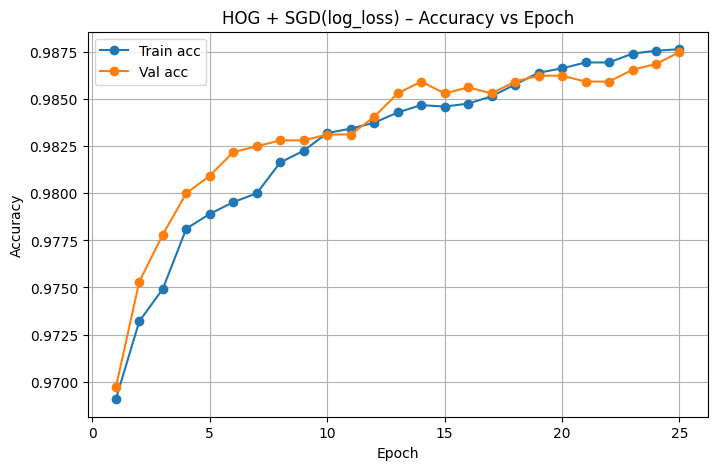

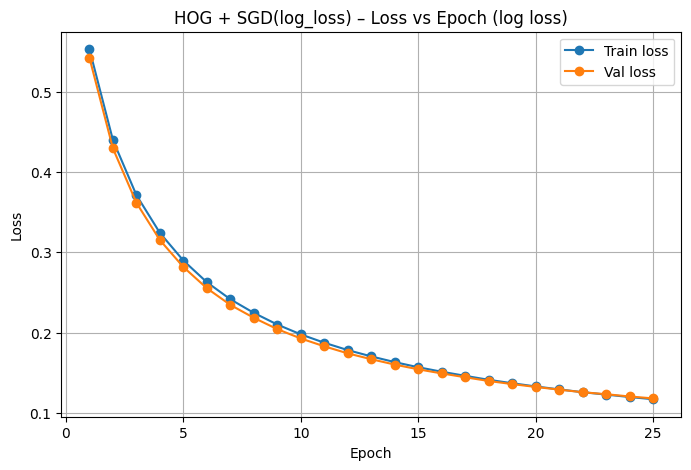

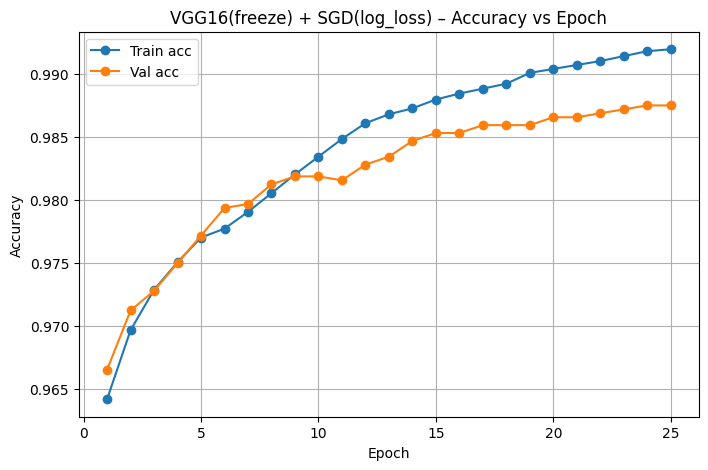

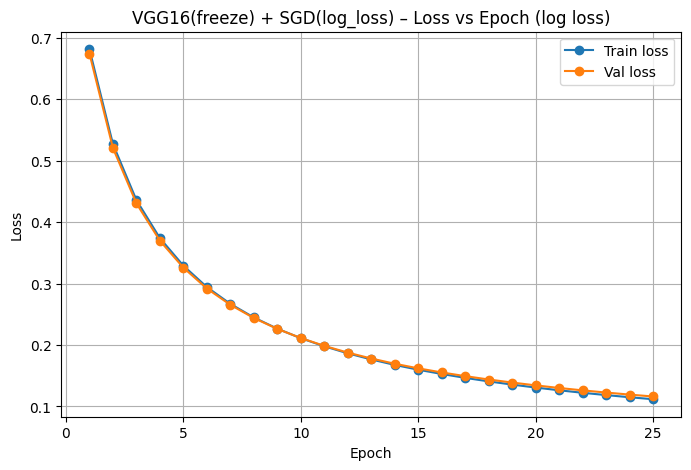

In [11]:

# =========================
# 10) ACC/LOSS theo "EPOCH" (minh hoạ) – dùng SGDClassifier
# =========================
def train_sgd_with_curves(X_train, y_train, X_val, y_val, epochs=20, lr=1e-4, seed=42):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)

    classes = np.unique(y_train)

    clf = SGDClassifier(
        loss="log_loss",
        learning_rate="constant",
        eta0=lr,
        max_iter=1,
        tol=None,
        random_state=seed
    )

    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []

    for ep in range(epochs):
        X_train_s, y_train = shuffle(X_train_s, y_train, random_state=seed + ep)

        if ep == 0:
            clf.partial_fit(X_train_s, y_train, classes=classes)
        else:
            clf.partial_fit(X_train_s, y_train)

        ytr_pred = clf.predict(X_train_s)
        yva_pred = clf.predict(X_val_s)

        train_acc_hist.append(accuracy_score(y_train, ytr_pred))
        val_acc_hist.append(accuracy_score(y_val, yva_pred))

        ytr_prob = clf.predict_proba(X_train_s)
        yva_prob = clf.predict_proba(X_val_s)

        train_loss_hist.append(log_loss(y_train, ytr_prob, labels=classes))
        val_loss_hist.append(log_loss(y_val, yva_prob, labels=classes))

    return train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist

def plot_epoch_curves(train_acc, val_acc, train_loss, val_loss, title_prefix):
    epochs = np.arange(1, len(train_acc)+1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_acc, marker="o", label="Train acc")
    plt.plot(epochs, val_acc, marker="o", label="Val acc")
    plt.title(f"{title_prefix} – Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, marker="o", label="Train loss")
    plt.plot(epochs, val_loss, marker="o", label="Val loss")
    plt.title(f"{title_prefix} – Loss vs Epoch (log loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

# Tách thêm validation từ train để vẽ curve (epoch)
X_tr_h, X_va_h, y_tr, y_va = train_test_split(
    X_train_hog, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
)
ta, va, tl, vl = train_sgd_with_curves(X_tr_h, y_tr, X_va_h, y_va, epochs=25, lr=1e-4, seed=RANDOM_SEED)
plot_epoch_curves(ta, va, tl, vl, "HOG + SGD(log_loss)")

X_tr_v, X_va_v, y_tr2, y_va2 = train_test_split(
    X_train_vgg, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
)
ta, va, tl, vl = train_sgd_with_curves(X_tr_v, y_tr2, X_va_v, y_va2, epochs=25, lr=1e-4, seed=RANDOM_SEED)
plot_epoch_curves(ta, va, tl, vl, "VGG16(freeze) + SGD(log_loss)")
